In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
%matplotlib inline


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def moving_average(array, window=3):
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# resize image to 224x224 since thats what resnet18 is trained on

# first, how do you want to transform/process your data?
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# second, fetch raw data
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [6]:
# labeled training data - this never changes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}
X_train, y_train = next(iter(dataloaders['train']))
X_train = X_train.to(device)
y_train = y_train.to(device)

X_train.shape  # images are 3x224x224

torch.Size([4, 3, 224, 224])

In [7]:
# unlabeled training data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=28, shuffle=True) for x in ['train', 'val']}
X_unlabeled, y_unlabeled = next(iter(dataloaders['train']))

# test data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50, shuffle=True) for x in ['train', 'val']}
X_test, y_test = next(iter(dataloaders['val']))

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)  # pin the model on the proper device
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

In [9]:
accuracy = []

n_epochs = 10
threshold = .9

for epoch in range(n_epochs):
    
    model_ft.train()
    
    # step 1: train on labeled data, which is never updated
    optimizer_ft.zero_grad()
    output = model_ft(X_train)
    real_loss = criterion(output, y_train)
    
    # step 2: view probabilities on unlabeled data
    output = model_ft(X_unlabeled)
    probs = F.softmax(output, dim=1)
    preds = probs.argmax(dim=1, keepdim=True)

    # step 3: train against pseudo labels only if it's high confidence
    fake_loss = 0
    counter = 0
    for prob, pred, c in zip(probs, preds, X_unlabeled):
        if (prob[pred] > threshold):
            counter += 1
            
            # step 4: generate strong augmentation data only if we'll use it
            X_strong = transforms.RandomErasing(p=1, ratio=(1, 1), scale=(0.01, 0.01), value=.1)(c)

            # step 5: learn against pseudo labels
            output = model_ft(X_strong.unsqueeze(0))
            fake_loss += criterion(output, pred)
    if counter > 0:
        fake_loss = fake_loss / counter  # take average fake loss
            
    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer_ft.step()
    
        
    # validate
    model_ft.eval()
    X_test, y_test = next(iter(dataloaders['val']))
    correct = 0
    test_output = model_ft(X_test)
    test_probs = F.softmax(test_output, dim=1)
    test_preds = test_probs.argmax(dim=1, keepdim=True)
    correct += test_preds.eq(y_test.view_as(test_preds)).sum().item()
    accuracy.append(correct / len(y_test))
    if epoch % (n_epochs / 10) == 0:
        print("epoch:", epoch, "accuracy", correct / len(y_test))

epoch: 0 accuracy 0.48
epoch: 1 accuracy 0.5
epoch: 2 accuracy 0.44
epoch: 3 accuracy 0.54
ping 4


KeyboardInterrupt: 

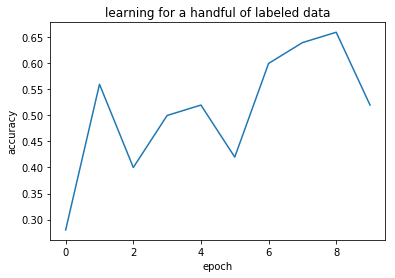

In [105]:
plt.title("learning for a handful of labeled data")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(moving_average(accuracy, window=1))

# step 1: establish baseline

In [106]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

In [107]:
baseline_accuracy = []

for epoch in range(n_epochs):
    model_ft.train()
    optimizer_ft.zero_grad()
    output = model_ft(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer_ft.step()
    
    # test
    model_ft.eval()
    X_test, y_test = next(iter(dataloaders['val']))
    correct = 0
    test_output = model_ft(X_test)
    test_probs = F.softmax(test_output, dim=1)
    test_preds = test_probs.argmax(dim=1, keepdim=True)
    correct += test_preds.eq(y_test.view_as(test_preds)).sum().item()
    baseline_accuracy.append(correct / len(y_test))
    if epoch % (n_epochs / 10) == 0:
        print("epoch:", epoch, "accuracy", correct / len(y_test))

epoch: 0 accuracy 0.64
epoch: 1 accuracy 0.52
epoch: 2 accuracy 0.54
epoch: 3 accuracy 0.5
epoch: 4 accuracy 0.5
epoch: 5 accuracy 0.56
epoch: 6 accuracy 0.56
epoch: 7 accuracy 0.54
epoch: 8 accuracy 0.58
epoch: 9 accuracy 0.6


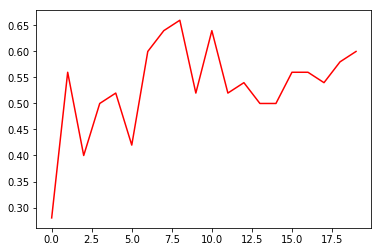

In [108]:
plt.plot(moving_average(baseline_accuracy, window=1))
plt.plot(moving_average(accuracy, window=1), c="r")